# Activity 1.5: experiments with parallel iterative methods

**Note:** this activity is really intended to be completed in class as part of a team.  If you participate in a team during class, there is no need to submit this activity on canvas.  If you are unable to be a part of class, there are submission instructions at the bottom.

4 points

**collaboration statement:**

## Login to PACE-ICE (1 point)

If you are working as part of a team, it is only necessary to have one team member login.

1. Sign in to the Georgia Tech VPN: https://oit.gatech.edu/services/end-point-computing/virtual-private-network-vpn
2. Once you are on the VPN, `ssh` into the instructional cluster:

`ssh GTID@coc-ice.pace.gatech.edu`

## Run an interactive job on a compute node (1 point)

If you are participating as part of a team in class, a work directory has been created for each team.  To start an interactive job on a compute node with 29 CPUs, use the appropriate command below:

`qsub -d /storage/home/hcocice1/tisaac3/share/cse6644/examples/ex1.5/team1 -q coc-ice -n -l nodes=1:ppn=28,walltime=02:00:00 -I
qsub -d /storage/home/hcocice1/tisaac3/share/cse6644/examples/ex1.5/team2 -q coc-ice -n -l nodes=1:ppn=28,walltime=02:00:00 -I
qsub -d /storage/home/hcocice1/tisaac3/share/cse6644/examples/ex1.5/team3 -q coc-ice -n -l nodes=1:ppn=28,walltime=02:00:00 -I
qsub -d /storage/home/hcocice1/tisaac3/share/cse6644/examples/ex1.5/team4 -q coc-ice -n -l nodes=1:ppn=28,walltime=02:00:00 -I`

If you are participating on your own after class, you will have to:

1. get the zip file of the directory from canvas
2. copy it to your own home directory on PACE-ICE
3. unzip it
4. run the same `qsub` command as above, but with your own example directory in place of one of the team directorys above.

After you run this command the shell will wait until a new subshell starts that is running on the compute node in the work directory.  You will know you are in the right place because running `ls` will show:

```
create_coloring.c              G3_circuit_color_5.petsc
G3_circuit_color_0.petsc       G3_circuit_color_5.petsc.info
G3_circuit_color_0.petsc.info  G3_circuit_color_6.petsc
G3_circuit_color_1.petsc       G3_circuit_color_6.petsc.info
G3_circuit_color_1.petsc.info  G3_circuit_color_7.petsc
G3_circuit_color_2.petsc       G3_circuit_color_7.petsc.info
G3_circuit_color_2.petsc.info  G3_circuit.petsc
G3_circuit_color_3.petsc       Makefile
G3_circuit_color_3.petsc.info  Makefile.user
G3_circuit_color_4.petsc       parallel_relaxation.py
G3_circuit_color_4.petsc.info  team.txt
```

## Parallel Experiments

We are going to solve systems with a matrix taken from here: <https://www.cise.ufl.edu/research/sparse/matrices/AMD/G3_circuit.html>.

**The goal today is to solve to a fixed tolerance as fast as possible.**

It is a symmetric positive definite matrix taken from a circuit simulation problem with $n=$ 1,585,478.

We are going to use the [PETSc library](https://www.mcs.anl.gov/petsc/) through the [petsc4py](https://www.mcs.anl.gov/petsc/) python interface.

The python file `parallel_relaxation.py` reads in the matrix, makes some default choices for how to solve the problem, and then solves it.  But, there is an options database that we can use to change the method used to solve the problem.

The work directory has a `Makefile` that has some predefined solver choices that correspond to

- basic iterative methods,
- block variants of basic iterative methods,
- reordered variants of basic iterative methods for increased parallelism.

For example to solve Jacobi, I run `make run_jacobi` and get output like the following:

```
PETSC_OPTIONS="-ksp_converged_reason -log_view -pc_type jacobi" PYTHONPATH=/storage/home/hcocice1/tisaac3/opt/pace-ice/root/usr/local/pace-apps/manual/packages/anaconda3/2020.02/lib/python3.7/site-packages:/usr/lib/oracle/11.2/lib64/python2.7/site-packages mpirun -np 28 -env MV2_ENABLE_AFFINITY 1 /usr/local/pace-apps/manual/packages/anaconda3/2020.02/bin/python ./parallel_relaxation.py 2>&1 | grep -v "WARNING" | grep "\(^Linear solve\|Solve:\|PCApply\)"
Linear solve converged due to CONVERGED_RTOL iterations 487
 1:           Solve: 1.1671e+00  48.6%  1.1325e+10  99.9%  5.941e+04  99.1%  6.243e+04       97.2%  4.900e+02  93.2%
PCApply              487 1.0 9.9183e-02 3.2 2.76e+07 1.0 0.0e+00 0.0e+00 2.0e+00  3  7  0  0  0   6  7  0  0  0  7785
```

Things to notice in this output:

- `mpirun -np 28`: The matrix was partitioned across 28 MPI processes during this solve
- `Linear solve converged due to CONVERGED_RTOL iterations 487`: The number of iterations
- `Solve: 1.1671e+00`: The first number after `Solve:` is the total time it took to solve the problem: this time it took 1.1 seconds
- `PCApply              487 1.0 9.9183e-02`: the first number is the number of times the preconditioning operation was called, the third number is the total time that was spent doing that operation.  If we take the ratio, we get the average time for each application of the preconditioner.  In this case it took $2 \times 10^{-4}$ seconds per iteration.

I can change the number of MPI processes used by adding an `NP` argument to the make command: for example `make run_jacobi NP=1`:

```
PETSC_OPTIONS="-ksp_converged_reason -log_view -pc_type jacobi" PYTHONPATH=/storage/home/hcocice1/tisaac3/opt/pace-ice/root/usr/local/pace-apps/manual/packages/anaconda3/2020.02/lib/python3.7/site-packages:/usr/lib/oracle/11.2/lib64/python2.7/site-packages mpirun -np 1 -env MV2_ENABLE_AFFINITY 1 /usr/local/pace-apps/manual/packages/anaconda3/2020.02/bin/python ./parallel_relaxation.py 2>&1 | grep -v "WARNING" | grep "\(^Linear solve\|Solve:\|PCApply\)"
Linear solve converged due to CONVERGED_RTOL iterations 487
 1:           Solve: 8.6492e+00  98.4%  1.1325e+10  99.9%  0.000e+00   0.0%  0.000e+00        0.0%  0.000e+00   0.0%
PCApply              487 1.0 1.1988e+00 1.0 7.72e+08 1.0 0.0e+00 0.0e+00 0.0e+00 14  7  0  0  0  14  7  0  0  0   644
```

Notice that the total time taken is greater, but the number of iterations is the same.  This agrees with our reading, that the Jacobi iteration does the same thing regardless of the way the problem is parallelized.

I have run `make run_jacobi NP=`1, 2, ..., 28, and I've plotted the number of iterations, total solve time, and time per preconditioner application below:

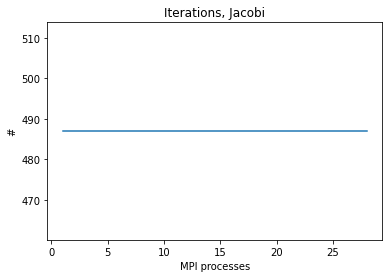

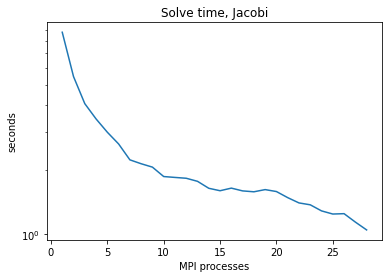

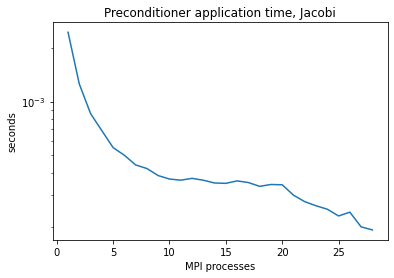

In [1]:
import numpy as np
import matplotlib.pyplot as plt

iterations=[487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487]
solve_time=[8.7986e+00,5.4557e+00,4.0732e+00,3.4545e+00,2.9927e+00,2.6375e+00,2.2220e+00,2.1306e+00,2.0540e+00,1.8558e+00,1.8382e+00,1.8217e+00,1.7625e+00,1.6350e+00,1.5925e+00,1.6379e+00,1.5896e+00,1.5744e+00,1.6120e+00,1.5786e+00,1.4782e+00,1.3963e+00,1.3682e+00,1.2813e+00,1.2386e+00,1.2435e+00,1.1358e+00,1.0436e+00]
apply_tots=[1.1901e+00,6.1087e-01,4.1736e-01,3.3482e-01,2.6919e-01,2.4393e-01,2.1530e-01,2.0556e-01,1.8770e-01,1.7962e-01,1.7697e-01,1.8119e-01,1.7686e-01,1.7068e-01,1.6988e-01,1.7535e-01,1.7163e-01,1.6347e-01,1.6739e-01,1.6674e-01,1.4591e-01,1.3416e-01,1.2725e-01,1.2173e-01,1.1159e-01,1.1717e-01,9.6939e-02,9.3233e-02]

iterations=np.array(iterations)
solve_time=np.array(solve_time)
apply_tots=np.array(apply_tots)
apply_pers=apply_tots/iterations

fig = plt.figure()
ax = fig.gca()
ax.set(title="Iterations, Jacobi", xlabel="MPI processes", ylabel="#")
ax.plot(list(range(1,29)), iterations)
plt.show()

fig = plt.figure()
ax = fig.gca()
ax.set(title="Solve time, Jacobi", xlabel="MPI processes", ylabel="seconds")
ax.semilogy(list(range(1,29)), solve_time)
plt.show()

fig = plt.figure()
ax = fig.gca()
ax.set(title="Preconditioner application time, Jacobi", xlabel="MPI processes", ylabel="seconds")
ax.semilogy(list(range(1,29)), apply_pers)
plt.show()

Things to notice:

- Iteration count is constant.
- Total solve time improves, but _perfect scaling_ would have seen the runtime cut in half every time the number of processes doubles.
- Time per application scale much like time per solve

**Activity 1 (1 point):** Pick one of the solver choices to investiget

- Team 1: `make run_block_jacobi`: one Jacobi block per MPI process
- Team 2: `make run_block_gauss_seidel_forward`: one Gauss-Seidel block per MPI process
- Team 3: `make run_sor_lex_forward`: Gauss-Seidel run in the original lexicographic order
- Team 4: `make run_sor_multicolor_forward`: Gauss-Seidel run in multicoloring order with 8 colors

(If you are working on your own after class, choose whichever one you'd like)

Gather datapoints for different `NP` for the scalability of the iterations, total solve time, and time per preconditioner application.  Present them as a team at the end of class and try to explain what you see.

(If you are working on your own after class, put your plots and answer in the cells below

In [2]:
# your plots here
### BEGIN SOLUTION
### END SOLUTION

your discussion here

**Activity 2 (1 point):** Try to find the iteration choice and number of MPI processes that minimizes the time to solution.  Report your findings.

your discussion here